In [14]:
# Import internal libraries
import json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
# Analyze reliability, bandwidth, energy
data = []
datadir = "data"
for bpc in range(1, 3):
    for alias in ["slow", "ispp", "ispp2", "ispp3", "ispp4"]:
        for att in range(16, 256, 32):
            # Real max attempts
            att = (att & 31) << (att >> 5)

            # Load and compute data
            try:
                diag = json.load(open(f"{datadir}/diag_{bpc}bpc_{alias}_{att}.json"))
                dt = np.loadtxt(f"{datadir}/dt_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                ivdd_and_dac = np.loadtxt(f"{datadir}/vdd_and_dac_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                ivsa = np.loadtxt(f"{datadir}/vsa_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                ivddio = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                ivddio_dac = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
            except OSError:
                continue
            power_tot = ivdd_and_dac * 0.9 + ivsa * 0.9 + ivddio_dac * 3.3 + ivddio * 3.3
            dt2 = diag["cycles"] * 1e-8
            energy_tot = power_tot * dt2
            bw = 2**16 * 48 * bpc / dt2 # bits per second
            energy_per_bit = energy_tot / 2**16 / 48 / bpc
            edp = energy_per_bit / bw

            # Load data into confmat
            try:
                confmat = np.loadtxt(f"{datadir}/confmat_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
            except OSError:
                postread = np.loadtxt(f"{datadir}/postread_{bpc}bpc_{alias}_{att}.csv", delimiter=',', dtype=np.int8)
                confmat = np.zeros(shape=(2**bpc, 2**bpc))
                for i in range(65536):
                    for j in range(48):
                        if j in [19,24,29,38,43]:
                            continue
                        confmat[j % (2**bpc)][postread[i][j]] += 1
                confmat = confmat.astype(int)
                np.savetxt(f"{datadir}/confmat_{bpc}bpc_{alias}_{att}.csv", confmat, fmt='%s', delimiter=',')
                print(confmat)

            # Symbol error magnitudes
            mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
            rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

            # Function to get Gray code string
            getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

            # Function to get Gray code error rate for each possible symbol confusion
            grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

            # BER and CER
            ber = (grayerr * confmat).sum() / confmat.sum()
            cer = 1 - confmat.trace() / confmat.sum()
            
            # Compose dataframe
            d = {"alias": alias, "att": att, "bpc": bpc, "dt": dt, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse}
            d.update(diag)
            data.append(d)
data = pd.DataFrame(data)
data

[[1432932    8860]
 [  15887 1360369]]
[[1439622    2170]
 [  14079 1362177]]
[[1441293     499]
 [   1736 1374520]]
[[1441636     156]
 [    333 1375923]]
[[1441724      68]
 [    104 1376152]]
[[1441745      47]
 [     81 1376175]]
[[1441752      40]
 [     37 1376219]]
[[1441763      29]
 [     48 1376208]]


,alias,att,bpc,dt,power_tot,energy_per_bit,edp,bw,cer,ber,...,rmse,successes,failures,reads,sets,resets,cycles,read_bits,set_bits,reset_bits
0,slow,16,1,0.3143916130065918,0.006434,6.428547e-10,6.423523e-17,1.000782e+07,0.179811,0.179811,...,0.424041,65536,96082,1818384,216592,1352867,31432693,15979386,1986864,9221204
1,slow,32,1,0.5184271335601807,0.006906,1.137883e-09,1.874972e-16,6.068799e+06,0.095836,0.095836,...,0.309574,65536,73890,2877104,314813,2244972,51834441,24399523,3006877,14992613
2,slow,64,1,0.9345607757568359,0.007105,2.110190e-09,6.267470e-16,3.366893e+06,0.026783,0.026783,...,0.163654,65536,56959,4783668,456311,3931380,93431189,39633384,4270023,27172879
3,slow,128,1,1.651125431060791,0.006919,3.631372e-09,1.905934e-15,1.905298e+06,0.008948,0.008948,...,0.094594,65536,46594,8169553,529941,7201712,165104290,52172474,4617743,38409590
4,slow,256,1,2.730008363723755,0.006596,5.723523e-09,4.966809e-15,1.152354e+06,0.003220,0.003220,...,0.056748,65536,35341,13250922,611793,12152386,272982788,69380138,4901431,54252414
5,slow,512,1,4.408488035202026,0.006486,9.089745e-09,1.273829e-14,7.135764e+05,0.000869,0.000869,...,0.029480,65536,27664,21025213,635760,19885020,440839720,85147848,4985845,69519017
6,slow,1024,1,6.834438323974609,0.006158,1.337953e-08,2.906775e-14,4.602877e+05,0.000174,0.000174,...,0.013173,65536,19429,32126641,639803,30972720,683426509,100941302,4999022,85062718
7,slow,2048,1,9.958831310272217,0.006035,1.910593e-08,6.048493e-14,3.158792e+05,0.000043,0.000043,...,0.006580,65536,12166,46512264,641657,45348521,995864288,116890834,4989922,100833457
8,ispp,16,1,0.2895090579986572,0.007662,7.048465e-10,6.484186e-17,1.087024e+07,0.011700,0.011700,...,0.108168,65536,72032,1665797,349823,956697,28938903,19211256,3971672,7872701
9,ispp,32,1,0.48732423782348633,0.007845,1.215068e-09,1.881974e-16,6.456348e+06,0.032457,0.032457,...,0.180157,65536,60169,2580758,303454,1917509,48723024,23385747,3203024,12742987


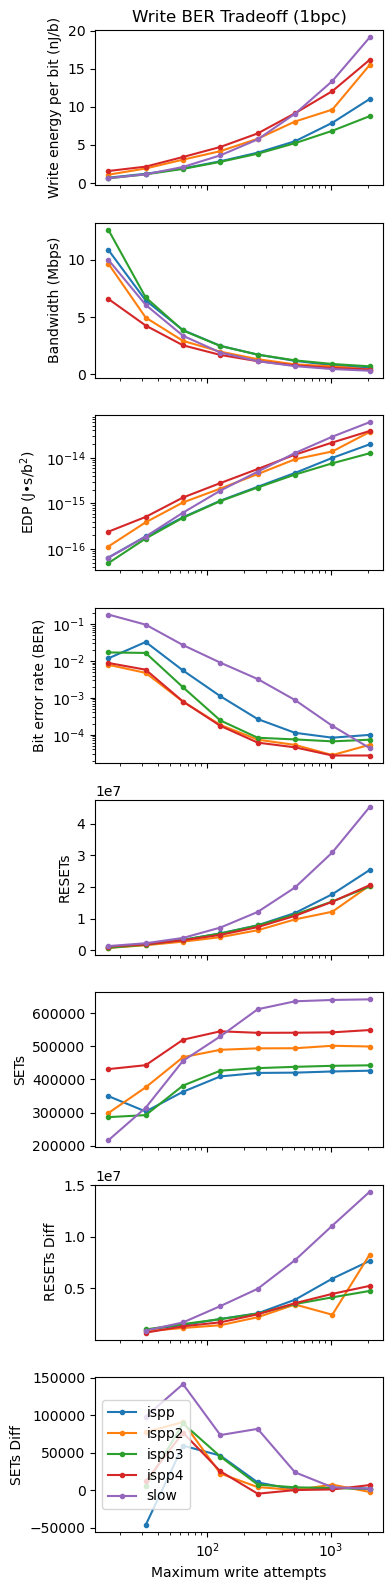

In [16]:
# Plot write BER tradeoff vs. attempts
fig, axs = plt.subplots(6, 1, figsize=(4,12), sharex=True)
for (bpc, alias), d in data.groupby(["bpc", "alias"]):
    plt.xlabel("Maximum write attempts")
    plt.xscale("log")
    axs[0].set_title(f"Write BER Tradeoff ({bpc}bpc)")
    axs[0].plot(d["att"], d["energy_per_bit"]*1e9, ".-", label=alias)
    # axs[0].set_yscale("log")
    axs[0].set_ylabel("Write energy per bit (nJ/b)")
    axs[1].plot(d["att"], d["bw"]/1e6, ".-", label=alias)
    # axs[1].set_yscale("log")
    axs[1].set_ylabel("Bandwidth (Mbps)")
    axs[2].plot(d["att"], d["edp"], ".-", label=alias)
    axs[2].set_yscale("log")
    axs[2].set_ylabel("EDP (J•s/b$^2$)")
    axs[3].plot(d["att"], d["ber"], ".-", label=alias)
    axs[3].set_yscale("log")
    axs[3].set_ylabel("Bit error rate (BER)")
    axs[4].plot(d["att"], d["resets"], ".-", label=alias)
    # axs[4].set_yscale("log")
    axs[4].set_ylabel("RESETs")
    axs[5].plot(d["att"], d["sets"], ".-", label=alias)
    # axs[5].set_yscale("log")
    axs[5].set_ylabel("SETs")
    # axs[6].plot(d["att"][1:], np.diff(d["resets"]), ".-", label=alias)
    # # axs[6].set_yscale("log")
    # axs[6].set_ylabel("RESETs Diff")
    # axs[7].plot(d["att"][1:], np.diff(d["sets"]), ".-", label=alias)
    # # axs[7].set_yscale("log")
    # axs[7].set_ylabel("SETs Diff")
plt.legend()
plt.tight_layout()
plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
plt.show()